## Chapter 1: Transformer Models

In [10]:
from transformers import pipeline

classifier = pipeline("sentiment-analysis")
classifier(
    [
        "I've been waiting for a HuggingFace course my whole life.",
        "I hate this so much!",
    ]
)

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


[{'label': 'POSITIVE', 'score': 0.9598049521446228},
 {'label': 'NEGATIVE', 'score': 0.9994558691978455}]

## Chapter 2: Using Hugging Face Transformers

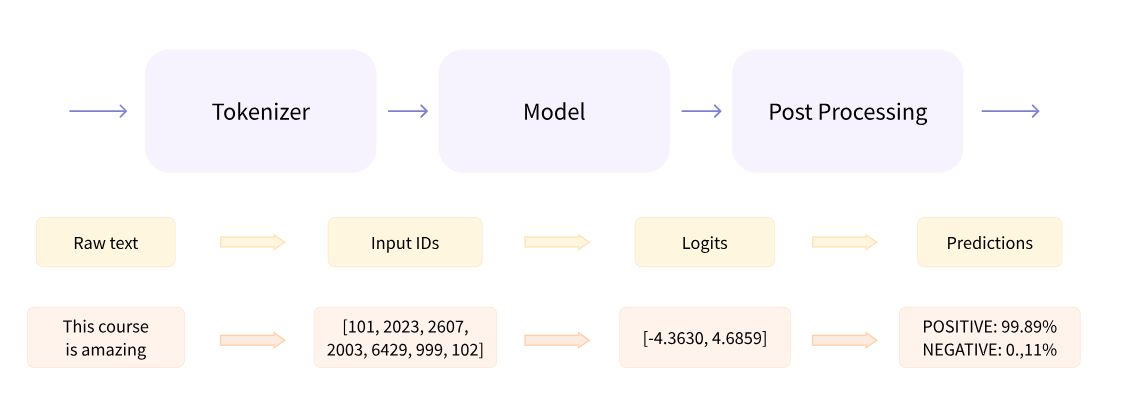

### Preprocessing with a tokenizer

A tokenizer is responsible for

 - Splitting the input into words, subwords, or symbols (like punctuation) that are called tokens
 - Mapping each token to an integer
 - Adding additional inputs that may be useful to the model

All this processing needs to be done in exactly the same ways as when the model was pretained.

In [11]:
from transformers import AutoTokenizer

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

Transformer models only accept `tensors` as input. To specify the type of tensors for output (PyTorch, TensorFlow, or NumPy), we use the `return_tensors` arg

In [12]:
raw_inputs = [
    "I've been waiting for a HuggingFace course my whole life.",
    "I hate this so much!",
]
inputs = tokenizer(raw_inputs, padding=True, truncation=True, return_tensors="pt")
print(inputs)

{'input_ids': tensor([[  101,  1045,  1005,  2310,  2042,  3403,  2005,  1037, 17662, 12172,
          2607,  2026,  2878,  2166,  1012,   102],
        [  101,  1045,  5223,  2023,  2061,  2172,   999,   102,     0,     0,
             0,     0,     0,     0,     0,     0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]])}


### Going through the model

Downloading pretrained models is the same as downloading tokenizer. Transformers provides an AutoModel class which also has a from_pretrained() method:


In [13]:
from transformers import AutoModel

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
model = AutoModel.from_pretrained(checkpoint)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

This architecture contains only the base Transformer module: given some inputs, it outputs what called hidden states, also known as features.

The vector output by the Transformer module is usually large. It generally has three dimensions:

- Batch size: The number of sequences processed at a time (2 in our example).
- Sequence length: The length of the numerical representation of the sequence (16 in our example).
- Hidden size: The vector dimension of each model input.

In [14]:
outputs = model(**inputs)
print(outputs.last_hidden_state.shape)

torch.Size([2, 16, 768])


Note that the ouputs ò Hugging Face Transformer models behave like namedtuples or dictionaries. Elements can be accessed by attributes or by key (`outputs['last_hidden_state']`), or even by index.

### Model heads: Making sense out of numbers

The model heads take the high-dimensional vector of hidden states as input and project them onto a different dimension. They are usually composed of one or a few linear layers:

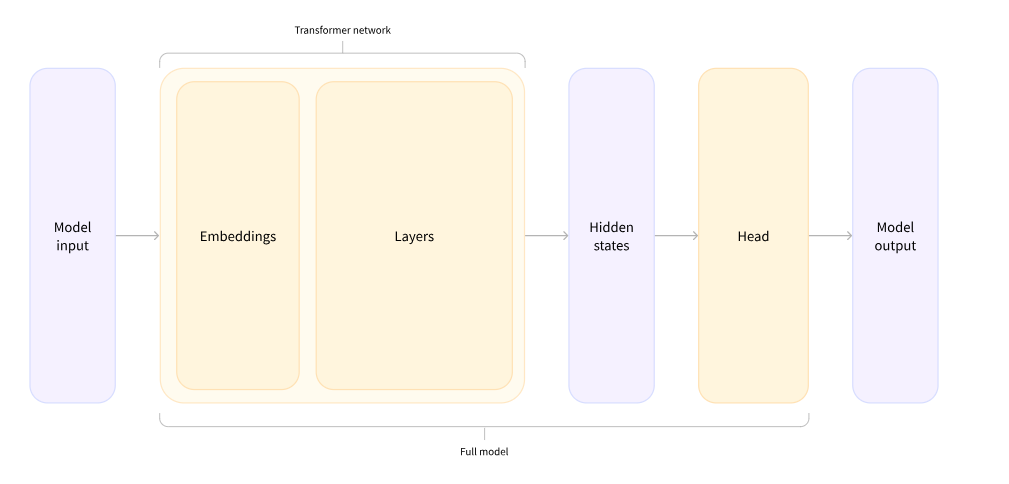

The output of the Transformer model is sent directly to the model head to be processed.

In this diagram, the model is represented by its embeddings layer and the subsequent layers. The embeddings layer converts each input ID in the tokenized input into a vector that represents the associated token. The subsequent layers manipulate those vectors using the attention mechanism to produce the final representation of the sentences.

For sequence classification head, we use AutoModelForSequenceClassification instead of AutoModel class.

In [15]:
from transformers import AutoModelForSequenceClassification

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)
outputs = model(**inputs)

print(outputs.logits.shape)

torch.Size([2, 2])


There are more architectures available:

- *Model (retrieve the hidden states)
- *ForCausalLM
- *ForMaskedLM
- *ForMultipleChoice
- *ForQuestionAnswering
- *ForSequenceClassification
- *ForTokenClassification
- and more...

### Post processing the output

The outputs from the model won't make sense. It has to go through softmax layer to get probabilities.

In [16]:
import torch

predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)

print(outputs.logits)
print(predictions)

tensor([[-1.5607,  1.6123],
        [ 4.1692, -3.3464]], grad_fn=<AddmmBackward0>)
tensor([[4.0195e-02, 9.5980e-01],
        [9.9946e-01, 5.4418e-04]], grad_fn=<SoftmaxBackward0>)


To get the label for each position, use the `id2label` attribute of the model config.

In [17]:
model.config.id2label

{0: 'NEGATIVE', 1: 'POSITIVE'}